In [1]:
import numpy as np
import matplotlib.pyplot as plt

import random
import numpy as np

import torch
import torch.nn as nn



import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
from torchvision.datasets import KMNIST
from torch.utils.data import DataLoader
from torchvision.models import resnet50, alexnet

from tqdm.notebook import tqdm, trange



random.seed(239)
np.random.seed(239)
torch.manual_seed(239)
torch.cuda.manual_seed(239)
torch.backends.cudnn.deterministic = True


OUTPUT_DIM = 10 
EPOCH_NUM = 4 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
basic_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])  

In [3]:
#Тренировочный и тестовый датасет
train_dataset = SVHN(
    root='./SVHN/train',
    split='train',
    transform=basic_transform,
    download=True
)

test_dataset = SVHN(
    root='./SVHN/test',
    split='test',
    transform=transforms.ToTensor(), 
    download=True
)

Using downloaded and verified file: ./SVHN/train\train_32x32.mat
Using downloaded and verified file: ./SVHN/test\test_32x32.mat


In [4]:
# Обертка датасетов
dataloaders = {
    'train': DataLoader(
        dataset=train_dataset,
        batch_size=128, 
        shuffle=True
    ),
    'val': DataLoader(
        dataset=test_dataset,
        batch_size=128, 
        shuffle=False
    )
}

In [5]:
# Модель классификатор
class SVHNClassifier(nn.Module):
    def __init__(self, ouput_dim):
        super(SVHNClassifier, self).__init__() # Определим класс как Нейронную сеть 
        self.model = resnet50(pretrained=True)  #Предобученная часть модели 
        
        # Замораживаем все веса
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Создание головы, которая работает с вектором-признаков
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64, ouput_dim)
        )
    # Свертка и предсказание
    def embed(self, x):
        return self.fc1(self.model(x))
    
    
    def forward(self, x):
        resnet_out = self.embed(x)
        return self.fc2(resnet_out)

In [6]:
model = SVHNClassifier(OUTPUT_DIM)
model = model.to(DEVICE)


loss_function = torch.nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

In [7]:
loss_hist = {'train': [], 'val': []}
acc_hist = {'train': [], 'val': []}
# Обучение модели через 4 поколения
# Если угадывает число все нормально
# Если нет, то дообучаем модель
for epoch in trange(EPOCH_NUM, desc='Whole pipeline'):
    
    for phase in ['train', 'val']:
        dataloader = dataloaders[phase]
        
        # Это условие необходимо так как у нас есть слой DropOut
        # И на валидации его принято фиксировать
        if phase == 'train':
            model.train() 
        elif phase == 'val':
            model.eval()
        
        running_loss = 0.
        running_acc = 0.
        
        # Проходимся по набору данных
        for (X_batch, y_batch) in tqdm(dataloader, desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            # Нормализуем наши данные
            X_batch = X_batch / 255
            X_batch = transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))(X_batch)
            
            # Переносим на устройство
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            # Для корректного обучения перед каждым шагом необходимо сбрасывать прошлые ошибки
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)
                
                loss_value = loss_function(y_pred, y_batch)
                y_pred_class = y_pred.argmax(dim=1)
                
                # На обучении мы хотим учиться в зависимости от ошибки
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()
                   
            # Аггрегируем ошибку и точность
            running_loss += loss_value.item()
            running_acc += (y_pred_class == y_batch.data).float().mean().data.cpu().numpy()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ', end='')
        
        loss_hist[phase].append(epoch_loss)
        acc_hist[phase].append(epoch_acc)

Whole pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2837 Acc: 0.1733 

Epoch: 1. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2280 Acc: 0.2015 

Epoch: 2. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2450 Acc: 0.1880 

Epoch: 2. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2172 Acc: 0.2049 

Epoch: 3. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2375 Acc: 0.1914 

Epoch: 3. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2113 Acc: 0.2073 

Epoch: 4. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2302 Acc: 0.1943 

Epoch: 4. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2053 Acc: 0.2099 

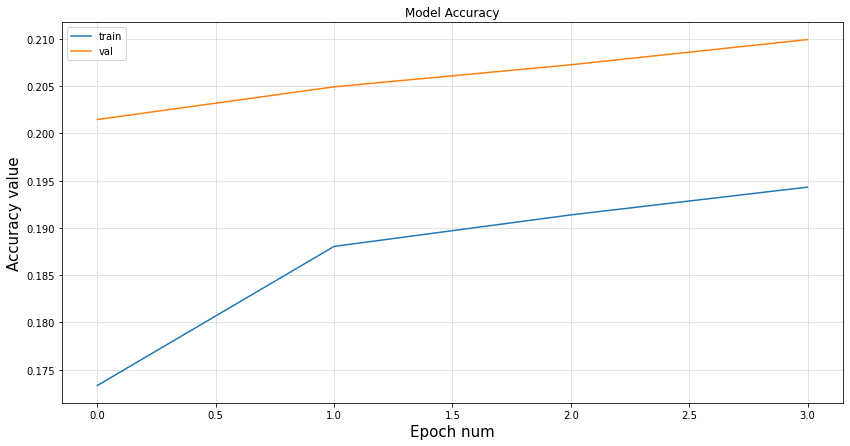

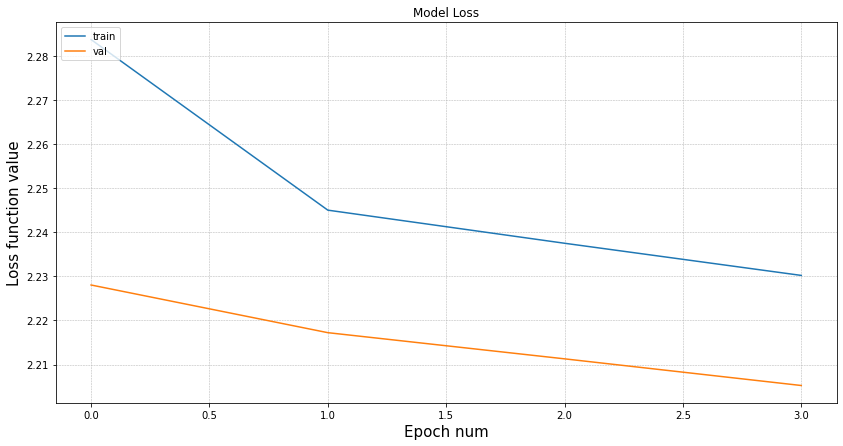

In [16]:
import matplotlib.pyplot as plt


# График точности
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

5


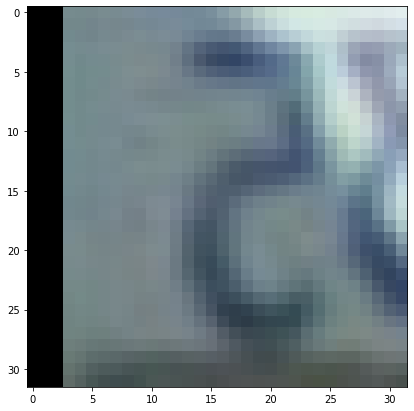

In [9]:
print(train_dataset[200][1])
img = train_dataset[200][0].detach().numpy()

plt.imshow(np.transpose(img, (1,2,0)))

In [10]:
train_items = [train_dataset[i] for i in range(1000)]
# Набор картинки и к какому класссу картинок относится
xs, ys = zip(*train_items)

xs = torch.stack(xs)
xs = transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))(xs)
xs.size()

torch.Size([1000, 3, 32, 32])

In [11]:
import umap.umap_ as umap

embs = model.model(xs)
points = umap.UMAP().fit_transform(embs.detach().numpy())
points.shape

(1000, 2)

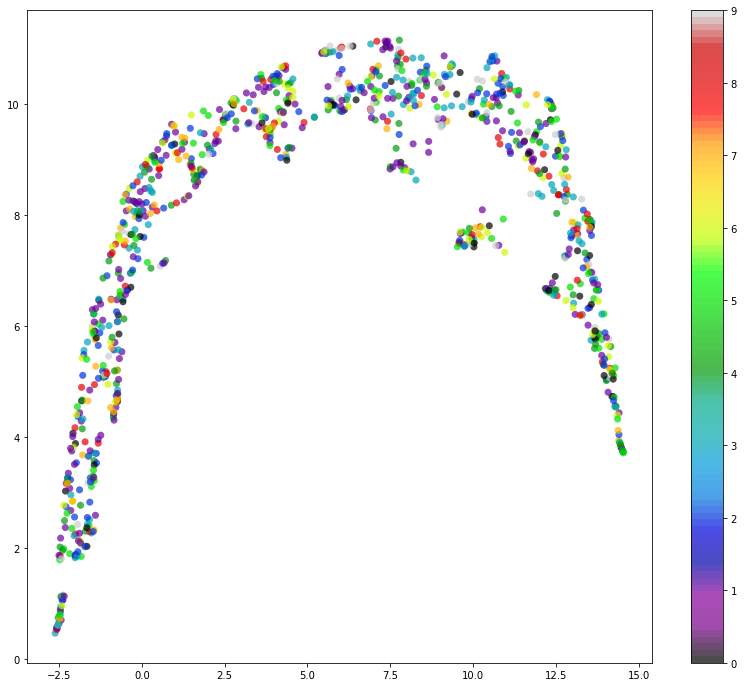

In [12]:
plt.figure(figsize=(14,12))
plt.scatter(points[:, 0], points[:, 1], c=ys, 
            edgecolor='none', alpha=0.7, s=50,
            cmap=plt.cm.get_cmap('nipy_spectral', 100))
plt.colorbar()
plt.show()

In [15]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('e')

features = xs.mean(dim=1).view(-1, 32 * 32)
writer.add_embedding(embs,
                     metadata=ys,
                     label_img=xs)
writer.close()